In [1]:
import gym
from gym import wrappers
import numpy as np
import matplotlib.pylab as plt

## Random search Cartpole

### How long a random agent lasts in cartpole

In [2]:
#set the cartpole environment
env = gym.make('CartPole-v0')

#for each episode record how many random steps are taken before the episode ends
steps_collector = []

#play many episodes to estimate the average length of an episode with a random agent
for _ in range(1000):
    #initialize environment
    env.reset()
    #count the steps until the episode ends
    num_steps = 0
    done = False
    while not done:
        num_steps += 1
        state, reward, done, info = env.step(env.action_space.sample())
    steps_collector.append(num_steps)
    
#average steps until the episode ends, if the agent acts randomly
np.mean(steps_collector)

21.818

### Random search for the optimal policy

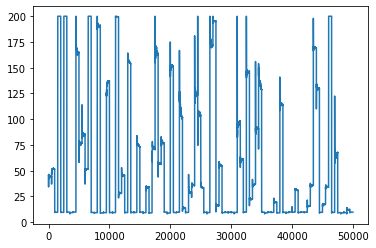

200.0


In [3]:
#defines an action function which acts with 1 if state x weights >0 otherwise 0
def choose_action(state, weights):
    if state.dot(weights) > 0:
        return 1
    else:
        return 0

max_steps = 0
steps_recorder = []

for t in range(100):
    
    #initialize random weights for choosing actions during episode
    weights = np.random.randn(env.observation_space.shape[0])

    #for each episode record how many random steps are taken before the episode ends
    steps_collector = []

    #play many episodes to estimate the average length of an episode with a random agent
    for _ in range(500):
        #initialize environment
        env.reset()
        state = env.state
        #count the steps until the episode ends
        num_steps = 0
        done = False
        while not done:
            action = choose_action(state, weights)
            num_steps += 1
            state, reward, done, info = env.step(action)
        steps_collector.append(num_steps)

        if np.mean(steps_collector) > max_steps:
            max_steps = np.mean(steps_collector)
            new_weights = weights

        steps_recorder.append(np.mean(steps_collector))

plt.plot(steps_recorder)
plt.show()
print(max_steps)

In [4]:
#check if the optimal random policy really works
env = gym.make('CartPole-v0')

env.reset()
state = env.state

num_steps = 0
done = False
while not done:
    action = choose_action(state, new_weights)
    num_steps += 1
    state, reward, done, info = env.step(action)
    
num_steps

200

## Q-Learning Cartpole

### Just Q-Learning no replay buffer, no target network

100
200
300
400
500
600
700
800
900
1000


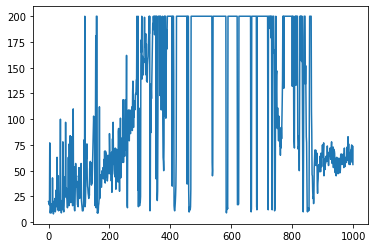

In [52]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt


class Model():
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, activation = 'selu', input_shape = [self.input_dim]),
            tf.keras.layers.Dense(self.output_dim, activation = 'linear')
        ])
    
    def predict(self, state):
        state = tf.convert_to_tensor([state])
        return self.network(state).numpy()
    
class Agent():
    def __init__(self, input_dim, hidden_dim, output_dim, optimizer):
        self.model = Model(input_dim, hidden_dim, output_dim)
        self.epsilon = 1.00
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.optimizer = optimizer
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))
        
    def learn(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + np.max(self.model.predict(next_state)[0])

        target_full = self.model.predict(state)
        target_full[0, action] = target

        with tf.GradientTape() as tape:
            tape.watch(self.model.network.trainable_variables)
            loss = tf.reduce_mean(tf.square(target_full - self.model.network(tf.convert_to_tensor([state]))))
        self.optimizer.minimize(loss, self.model.network.trainable_variables, tape = tape)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
def play_one_episode():
    state = env.reset()
    return_ = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        return_ += 1
        reward = reward if not done else -5.0
        agent.learn(state, action, reward, next_state, done)
        state = next_state
    
    return return_

env = gym.make('CartPole-v0')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
agent = Agent(4, 10, 2, optimizer = optimizer)

sum_rewards = []
for t in range(1000):
    sum_rewards.append(play_one_episode())
    if (t+1) % 100 == 0:
        print(t+1)
        
plt.plot(sum_rewards)
plt.show()

### Q-Learning with replay buffer

100
200
300
400
500


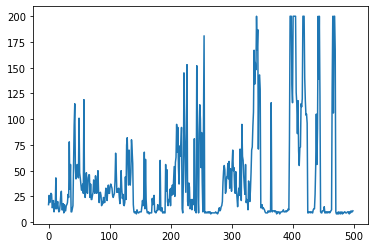

In [55]:
import random
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt
from collections import deque

class Model():
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, activation = 'selu', input_shape = [self.input_dim]),
            tf.keras.layers.Dense(self.output_dim, activation = 'linear')
        ])
    
    def predict(self, state):
        state = tf.convert_to_tensor([state])
        return self.network(state).numpy()
    
class Agent():
    def __init__(self, input_dim, hidden_dim, output_dim, optimizer):
        self.model = Model(input_dim, hidden_dim, output_dim)
        self.epsilon = 1.00
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.optimizer = optimizer
        self.memory = deque(maxlen = 2000)
        self.batch_size = 16
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.model.predict(state))
        
    def learn(self):
        if len(self.memory) <= self.batch_size:
            minibatch = self.memory
        else:
            minibatch = random.sample(self.memory, self.batch_size)
        
        for m in minibatch:
            state, action, reward, next_state, done = m
            if done:
                target = reward
            else:
                target = reward + np.max(self.model.predict(next_state)[0])

            target_full = self.model.predict(state)
            target_full[0, action] = target

            with tf.GradientTape() as tape:
                tape.watch(self.model.network.trainable_variables)
                loss = tf.reduce_mean(tf.square(target_full - self.model.network(tf.convert_to_tensor([state]))))
            self.optimizer.minimize(loss, self.model.network.trainable_variables, tape = tape)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
def play_one_episode():
    state = env.reset()
    return_ = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        return_ += 1
        reward = reward if not done else -5.0
        agent.memory.append((state, action, reward, next_state, done))
        agent.learn()
        state = next_state
    
    return return_

env = gym.make('CartPole-v0')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
agent = Agent(4, 10, 2, optimizer = optimizer)

sum_rewards = []
for t in range(500):
    sum_rewards.append(play_one_episode())
    if (t+1) % 100 == 0:
        print(t+1)
        
plt.plot(sum_rewards)
plt.show()

### Q-Learning with replay buffer and target network

Iteration: 100, Average return over the last 30 episodes: 72.24
Current epsilon: 0.0100
Iteration: 200, Average return over the last 30 episodes: 115.24
Current epsilon: 0.0100
Iteration: 300, Average return over the last 30 episodes: 123.38
Current epsilon: 0.0100
Iteration: 400, Average return over the last 30 episodes: 132.53
Current epsilon: 0.0100
Iteration: 500, Average return over the last 30 episodes: 137.81
Current epsilon: 0.0100


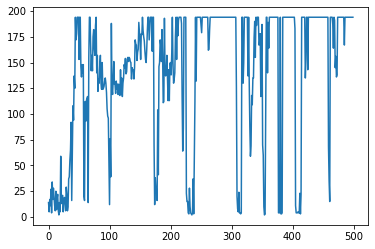

In [123]:
import gym
import random
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pylab as plt

class Model():
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.prediction_network = self.generate_network()
        self.target_network = self.generate_network()
        
    def generate_network(self):
        network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, activation = 'selu', input_shape = [self.input_dim]),
            tf.keras.layers.Dense(self.output_dim, activation = 'linear')
        ])
        return network
    
    def update_target_network(self):
        self.target_network.set_weights(self.prediction_network.get_weights())
    
class Agent():
    def __init__(self, input_dim, hidden_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.epsilon = 1.00
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01
        self.model = Model(self.input_dim, self.hidden_dim, self.output_dim)
        self.memory = deque(maxlen = 2000)
        self.batch_size = 16
        self.gamma = 0.999
        self.optimizer = optimizer
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(np.arange(self.output_dim))
        else:
            state = tf.convert_to_tensor([state])
            return np.argmax(self.model.prediction_network(state).numpy()[0])
        
    
    def learn_stepwise(self):
        if len(self.memory) <= self.batch_size:
            minibatch = self.memory
        else:
            minibatch = random.sample(self.memory, self.batch_size)
        for m in minibatch:
            state, action, reward, next_state, done = m
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.max(self.model.target_network(tf.convert_to_tensor([next_state])).numpy()[0])

            full_targets = self.model.prediction_network(tf.convert_to_tensor([state])).numpy()
            full_targets[0, action] = target

            with tf.GradientTape() as tape:
                tape.watch(self.model.prediction_network.trainable_variables)
                loss = tf.reduce_sum(tf.square(full_targets - self.model.prediction_network(tf.convert_to_tensor([state]))))

            self.optimizer.minimize(loss, self.model.prediction_network.trainable_variables, tape = tape)

        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn_batchwise(self):
        if len(self.memory) <= self.batch_size:
            minibatch = self.memory
        else:
            minibatch = random.sample(self.memory, self.batch_size)
        
        state_batch, target_batch = [], []
        for m in minibatch:
            state, action, reward, next_state, done = m
            state_batch.append(state)
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.max(self.model.target_network(tf.convert_to_tensor([next_state])).numpy()[0])#
 
            full_targets = self.model.prediction_network(tf.convert_to_tensor([state])).numpy()
            full_targets[0, action] = target
            target_batch.append(full_targets[0])

        with tf.GradientTape() as tape:
            tape.watch(self.model.prediction_network.trainable_variables)
            prediction_batch = self.model.prediction_network(np.array(state_batch))
            target_batch = np.array(target_batch)
            loss = tf.reduce_mean(tf.square(target_batch - prediction_batch))

        self.optimizer.minimize(loss, self.model.prediction_network.trainable_variables, tape = tape)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

            
env = gym.make('CartPole-v0')
agent = Agent(input_dim = 4, 
              hidden_dim = 10,
              output_dim = 2,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.025))
agent.model.update_target_network()

time_step = 0
sum_returns = []

for t in range(500):

    state = env.reset()
    done = False
    return_ = 0.0
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        reward = reward if not done else -5.0
        return_ += reward

        agent.memory.append((state, action, reward, next_state, done))
        agent.learn_batchwise()

        if time_step % 100 == 0:
            agent.model.update_target_network()
        time_step += 1

        state = next_state
        
    sum_returns.append(return_)
    if (t + 1) % 100 == 0:
        print(f'Iteration: {t+1}, Average return over the last 30 episodes: {np.mean(sum_returns[:-30]):.2f}')
        print(f'Current epsilon: {agent.epsilon:.4f}')
        
plt.plot(sum_returns)
plt.show()

## Policy Gradient Cartpole

Iteration: 50, Average return over the last 30 episodes: 22.25
Iteration: 100, Average return over the last 30 episodes: 25.84285714285714
Iteration: 150, Average return over the last 30 episodes: 28.058333333333334
Iteration: 200, Average return over the last 30 episodes: 32.83529411764706
Iteration: 250, Average return over the last 30 episodes: 37.21363636363636
Iteration: 300, Average return over the last 30 episodes: 42.89259259259259
Iteration: 350, Average return over the last 30 episodes: 48.55
Iteration: 400, Average return over the last 30 episodes: 56.78378378378378
Iteration: 450, Average return over the last 30 episodes: 65.57380952380953
Iteration: 500, Average return over the last 30 episodes: 73.29361702127659
Iteration: 550, Average return over the last 30 episodes: 81.48653846153846
Iteration: 600, Average return over the last 30 episodes: 90.09473684210526
Iteration: 650, Average return over the last 30 episodes: 97.22096774193548
Iteration: 700, Average return over 

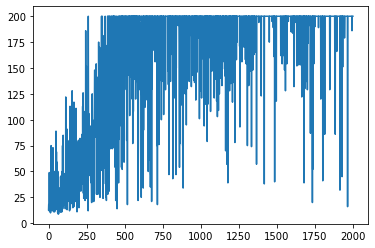

In [125]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt

class Policy():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.output_dim, activation = 'linear', input_shape = [self.input_dim]) 
        ])
    
    def call(self, state):
        return self.network(state)


class Agent():
    def __init__(self, optimizer):
        self.policy = Policy(4, 2)
        self.optimizer = optimizer
        
    def act(self, state):
        state = tf.convert_to_tensor([state])
        action_probs = tf.nn.softmax(self.policy.network(state))
        return np.random.choice([0, 1], p = action_probs.numpy()[0]) 
    
    def learn(self, actions, states, rewards, discount_rate):
        with tf.GradientTape() as tape:
            tape.watch(self.policy.network.trainable_variables)
            discounted_rs = discounted_returns(rewards, discount_rate)
            logits = self.policy.network(np.array(states))
            labels = np.array(actions)
            neg_log_policy_probs = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
            loss = tf.reduce_mean(neg_log_policy_probs * discounted_rs)
        self.optimizer.minimize(loss, self.policy.network.trainable_variables, tape = tape)

    
def discounted_returns(rewards, discount_rate):
    T = len(rewards)
    return_ = 0.0

    discounted_returns = np.zeros(T)
    for t in reversed(range(T)):
        discounted_returns[t] = return_ + discount_rate * rewards[t]
        return_ = discounted_returns[t]
    
    discounted_returns -= np.mean(discounted_returns)
    discounted_returns /= np.std(discounted_returns)
    return discounted_returns


env = gym.make('CartPole-v0')
agent = Agent(tf.keras.optimizers.Adam(learning_rate = 0.01))

sum_returns = []
for i in range(2000):
    actions, states, rewards = [], [], []
    state = env.reset()
    sum_return = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        sum_return += 1
        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1.0
        actions.append(action_one_hot)
        states.append(state)
        rewards.append(reward)
        state = next_state

    agent.learn(actions, states, rewards, discount_rate = 0.95)
    sum_returns.append(sum_return)
    
    if (i+1) % 50 == 0:
        print(f'Iteration: {i+1}, Average return over the last 30 episodes: {np.mean(sum_returns[:-30])}')
        
plt.plot(sum_returns)
plt.show()

## A2C Cartpole

Iteration: 50, Average return over the last 30 episodes: 40.40
Iteration: 100, Average return over the last 30 episodes: 47.10
Iteration: 150, Average return over the last 30 episodes: 46.81
Iteration: 200, Average return over the last 30 episodes: 54.91
Iteration: 250, Average return over the last 30 episodes: 60.17
Iteration: 300, Average return over the last 30 episodes: 64.65
Iteration: 350, Average return over the last 30 episodes: 65.36
Iteration: 400, Average return over the last 30 episodes: 68.16
Iteration: 450, Average return over the last 30 episodes: 73.06
Iteration: 500, Average return over the last 30 episodes: 81.99
Iteration: 550, Average return over the last 30 episodes: 92.66
Iteration: 600, Average return over the last 30 episodes: 101.66
Iteration: 650, Average return over the last 30 episodes: 109.59
Iteration: 700, Average return over the last 30 episodes: 116.33
Iteration: 750, Average return over the last 30 episodes: 120.02
Iteration: 800, Average return over t

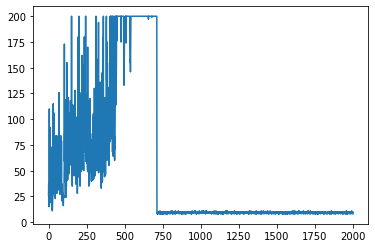

In [125]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pylab as plt


class Network():
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
    def generate_network(self):
        network = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, activation = 'selu', input_shape = [self.input_dim]),
            tf.keras.layers.Dense(self.output_dim, activation = 'linear')
        ])
        return network

class Agent():
    def __init__(self, input_dim, hidden_dim, output_dim, lr_a, lr_c):
        self.actor_network = Network(input_dim, hidden_dim, output_dim).generate_network()
        self.critic_network = Network(input_dim, hidden_dim, 1).generate_network()
        self.optimizer_actor = tf.keras.optimizers.Adam(learning_rate = lr_a)
        self.optimizer_critic = tf.keras.optimizers.Adam(learning_rate = lr_c)

        
    def act(self, state):
        state = tf.convert_to_tensor([state])
        action_probs = tf.nn.softmax(self.actor_network(state))
        return np.random.choice([0, 1], p = action_probs.numpy()[0]) 


env = gym.make('CartPole-v0')

agent = Agent(4, 10, 2, 0.01, 0.01)
sum_rewards = []

for t in range(2000):
    state = env.reset()
    done = False
    sum_reward = 0.0
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        sum_reward += reward
        reward = reward if not done else -5.0
        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1.0

        #update the actor network
        with tf.GradientTape() as tape:
            tape.watch(agent.actor_network.trainable_variables)
            #calculate negative log of actor probability
            logits = agent.actor_network(tf.convert_to_tensor([state]))
            neg_log_prob = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = action_one_hot)
            if done:
                target = reward
            else:
                target = reward + agent.critic_network(tf.convert_to_tensor([next_state])).numpy()[0]
            return_ = target - agent.critic_network(tf.convert_to_tensor([state])).numpy()[0]
            policy_loss = neg_log_prob * return_

        agent.optimizer_actor.minimize(policy_loss, agent.actor_network.trainable_variables, tape = tape)

        #update the critic network
        with tf.GradientTape() as tape:
            tape.watch(agent.critic_network.trainable_variables)
            critic_loss = tf.reduce_mean(tf.square((reward + agent.critic_network(tf.convert_to_tensor([next_state]))) - agent.critic_network(tf.convert_to_tensor([state]))))

        agent.optimizer_critic.minimize(critic_loss, agent.critic_network.trainable_variables, tape = tape)

        state = next_state
        
    sum_rewards.append(sum_reward)
    if (t+1) % 50 == 0:
        print(f'Iteration: {t+1}, Average return over the last 30 episodes: {np.mean(sum_rewards[:-30]):.2f}')
        
plt.plot(sum_rewards)
plt.show()